In [124]:
import numpy as np
import math as math
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline

Считаем данные о пожарах и приведём их к удобному для нас формату.

In [125]:
def get_shuffled_data():
    with open('forestfires.csv', 'r') as file:
        main_data = list(csv.reader(file))
    area = []
    data = main_data[1:]
    N = len(data)
    for i in range(N):
        data[i].pop(3) # отбрасываем день
        data[i].append(1.0) # координата, тождественно равная единице

    random.shuffle(data)    

    for i in range(N):
        data[i][2] = 1.0 if data[i][2] in ['jun', 'jul', 'aug'] else 0.0
        data[i] = [float(number) for number in data[i]]
        area.append(data[i][-2])
        del (data[i][-2])
       
    return data, area

data, area = get_shuffled_data()
N = len(data)

# Регрессионная модель. <br>

Имеется $N$ векторов $X_1,\dots,X_N$.

Рассмотрим вектор $X_i = (X_i^{1}, X_i^{2},\dots,X_i^{K}), \ \ \text{где} \ \ K = 13$ — данные, дающие информацию о конкретном пожаре. Будем считать, что $\forall i\in\{1,\dots,N\}$ мы измерили только координату $X_i^{K}$ (площадь пожара - area), а остальные данные $X_i^{1}, X_i^{2},\dots,X_i^{K-1}$ нам известны. Тогда area можно представить как линейную комбинацию остальных данных: 

$$\forall i\in\{1,\dots,N\} \ \ X_i^{K} = \theta_1X_i^{1} + \theta_2X_i^{2}+\dots+\theta_{K-1}X_i^{K-1}.$$
Оценим параметры $\theta = (\theta_1,\dots,\theta_{K-1})^T$. 

$$\theta=(Z^TZ)^{-1}Z^T\hat X,$$

где $\hat X$ - данные о площадях пожаров, $Z$ - остальные данные.

Оценка для area (известны первые $K - 1 = 12$ координат каждого вектора) равна: $ \hat{A} = Z\theta. $ 

Разделим данные в отношении 7:3 и построим регрессионную модель по первой части выборки.

In [126]:
data_1 = data[:N*7//10]
data_2 = data[N*7//10+1:]
area_1 = area[:N*7//10]
area_2 = area[N*7//10+1:]

In [127]:
def estimate(z, x):    
    Z = np.array(z)
    X = np.array(x)
    Z_T = Z.T
    theta = np.linalg.inv(Z_T @ Z) @ Z_T @ X.T
    return theta

In [128]:
def error(z, x, theta):
    Z = np.array(z)
    X = np.array(x)
    
    alpha = (np.array(X.T - Z @ theta))**2
    return math.sqrt(alpha.sum()/(len(x) - 12))

Посчитаем среднеквадратичную ошибку $\hat{\sigma} = \frac{||X-Z\hat{\theta}||^2}{n-k}$ по второй части выборки.

In [129]:
theta_1 = estimate(data_1, area_1)
err_1 = error(data_2, area_2, theta_1)
print("Среднеквадратичная ошибка: ", err_1)

Среднеквадратичная ошибка:  30.760855696442537


Сделаем для area преобразование $f(x) = ln(x + c)$ и построим для нее новую регрессионную модель. Посчитаем среднеквадратичную ошибку для преобразованных значений. Найдем $c$, при котором среднеквадратичное отклонение минимально.

In [130]:
def estimate_2(z, x, c):    
    Z = np.array(z)
    X = np.array(x)
    X = np.log(X + c)
    Z_T = Z.T
    
    theta = np.linalg.inv(Z_T @ Z) @ Z_T @ X.T
    return theta

def error_2(z, x, theta):
    Z = np.array(z)
    X = np.array(x)
    
    alpha = (np.array(X.T - np.exp(Z @ theta) + c))**2
    return math.sqrt(alpha.sum()/(len(x) - 12))

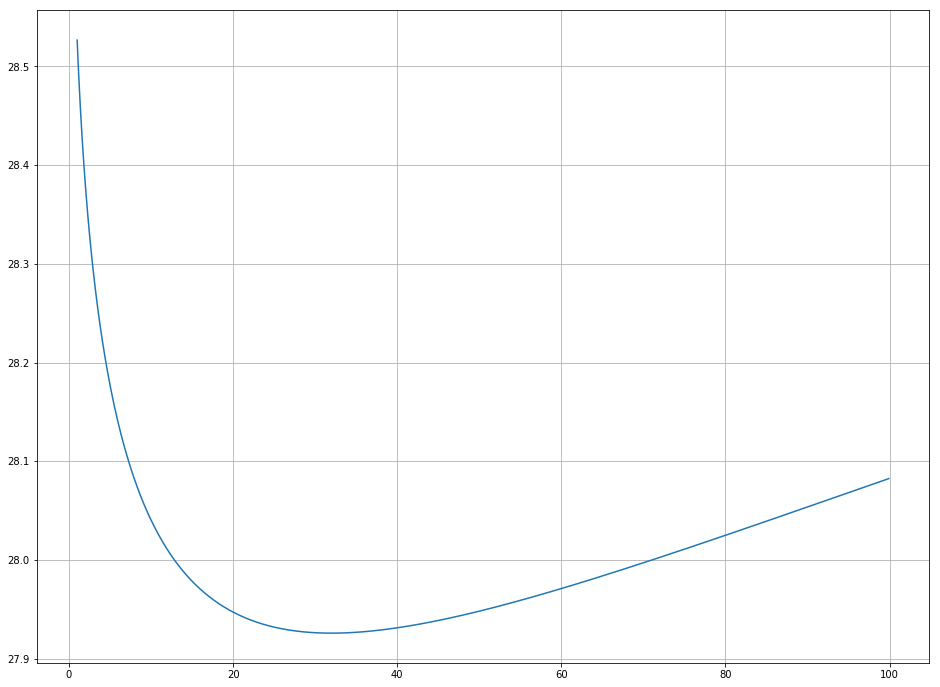

Минимальная ошибка:  27.9258441399516
c:  32.0


In [131]:
err = []

min_err = np.inf
for c in np.arange(1,100,0.1):
    theta_2 = estimate_2(data_1, area_1, c)
    err.append(error_2(data_2, area_2, theta_2))
    if error_2(data_2, area_2, theta_2) < min_err:
        min_err = error_2(data_2, area_2, theta_2)
        min_c = c
 
plt.figure(figsize=(16, 12))
plt.plot(np.arange(1,100,0.1), err)
plt.grid()
plt.show()

print("Минимальная ошибка: ", min_err)
print("c: ", min_c)

Разобьём выборку в соотношении 7:3 разными способами и найдем ошибки при полученном выше коэффициенте $c$.

In [132]:
for i in range(40):
    data, area = get_shuffled_data()
    data_1 = data[:N*7//10]
    data_2 = data[N*7//10+1:]
    area_1 = area[:N*7//10]
    area_2 = area[N*7//10+1:]
    theta_3 = estimate_2(data_1, area_1, min_c)
    err = error_2(data_2, area_2, theta_3)
    print(err)

80.15689698288567
76.14918023488637
79.89575031440945
101.08283928792196
140.93172352793184
78.15869707521755
105.68453155919126
75.79931462926564
87.26824979373241
82.74609214402713
71.96273513485082
83.89735355524338
106.16509379659281
122.47492349475074
74.92221704026854
79.45753424802461
101.45887164718779
98.40581871563934
125.08811315477118
102.68953292387837
72.44452909678881
123.24180167024477
83.30068942794945
73.62770450112006
122.70436370993619
138.67581048584566
121.6686326167025
120.94579583951042
79.56669961563745
80.63153893831921
73.83596775371446
120.90106600154216
101.04610542212485
71.46030510777706
80.66423686439767
82.23857426681978
108.23890088324222
98.02796860945986
121.83797437510216
81.8189531521682


# Вывод:

Ошибка, полученная при преобразовании $f(x)=ln(x+c)$ близка к ошибке на исходных непреобразованных данных.
Видим, что в любом случае среднеквадратичное отклонение велико. К тому же, среднеквадратичное отклонение очень сильно зависит от способа разбиения. Поэтому линейная регрессия работает плохо.